# 📈 Tendencias – BITNET 1.58


❤️ Creado por [@Edison_Bejarano](https://github.com/EjbejaranosAI/llm-hub/blob/main/mastery/notebooks/).

## 📝 Introducción
En este notebook exploraremos la **cuantización** de un modelo **LLaMA** mediante la transformación de sus capas lineales tradicionales (`nn.Linear`) en capas **BitLinear** 🔢, donde los pesos se representan en formato binario (0/1).  

Esta técnica permite:  
- 💾 Reducir significativamente los requerimientos de memoria.  
- ⚡ Disminuir la carga de cómputo.  
- 🖥️ Hacer posible la inferencia en hardware limitado.  

El enfoque implementado aquí corresponde a una **cuantización post-entrenamiento**, ya que entrenar con **Quantization-Aware Training** necesitaría GPUs avanzadas como una **NVIDIA A100**.  

🎯 Este notebook tiene un objetivo **educativo**: mostrar cómo se reemplazan las capas lineales por **capas bitlineales** y cómo trabajar con modelos cuantizados en entornos limitados.


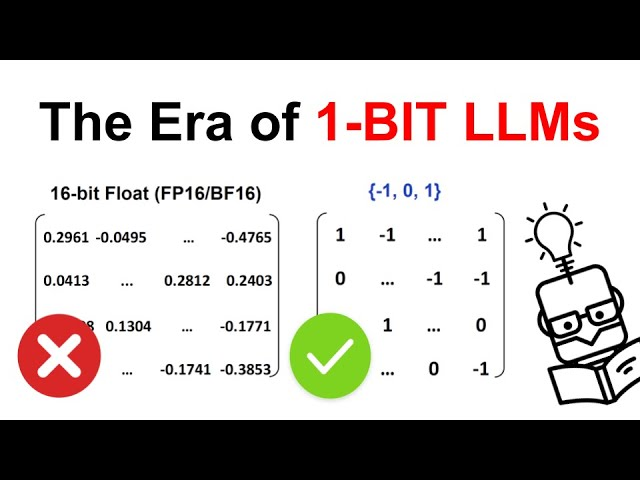[link text](![image.png]()https://)

### 1. Setup e importe de librerías

In [1]:
!pip install -q transformers datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.6 MB/s eta 0:00:00


In [13]:
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, PreTrainedModel
from transformers.models.llama.modeling_llama import *
import torch
from torch import nn
import torch.nn.functional as F
from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder, snapshot_download
from huggingface_hub import snapshot_download
from transformers import LlamaConfig

In [10]:
# Recomiendo crear una clave token en Huggingface
login(token="hf_VxrmX")

### 2. Bitnet Util functions

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import LlamaConfig, LlamaForCausalLM, PreTrainedModel

# Quantization functions
def activation_quant(x):
    scale = 127.0 / x.abs().max(dim=-1, keepdim=True).values.clamp(min=1e-5)
    y = (x * scale).round().clamp(-128, 127)
    y = y / scale
    return y

def weight_quant(w):
    scale = 1.0 / w.abs().mean().clamp(min=1e-5)
    u = (w * scale).round().clamp(-1, 1)
    u = u / scale
    return u

# BitLinear replacement
class BitLinear(nn.Linear):
    def forward(self, x):
        w_quant = self.weight + (weight_quant(self.weight) - self.weight).detach()
        x_quant = x + (activation_quant(x) - x).detach()
        return F.linear(x_quant, w_quant, self.bias)

# Convert all nn.Linear layers to BitLinear
def convert_to_bitnet(model, copy_weights=True):
    for name, module in model.named_modules():
        for child_name, child in module.named_children():
            if isinstance(child, nn.Linear):
                bitlinear = BitLinear(child.in_features, child.out_features, bias=(child.bias is not None))
                if copy_weights:
                    bitlinear.weight.data = child.weight.data.clone()
                    if child.bias is not None:
                        bitlinear.bias.data = child.bias.data.clone()
                setattr(module, child_name, bitlinear)

# Custom BitNet classes
class BitNetConfig(LlamaConfig):
    model_type = "bitnet"

class BitNetModel(PreTrainedModel):
    config_class = BitNetConfig

    def __init__(self, config):
        super().__init__(config)
        self.model = LlamaForCausalLM(config)
        convert_to_bitnet(self.model, copy_weights=True)

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)


### 3. Load model and transform to bitnet

In [9]:
llm_local_path = "./models/Llama3-8B-ITCL-Bitnet1.6B/"

snapshot_download(
    repo_id="ejbejaranos/Llama3-8B-ITCL-Bitnet1.6B",
    local_dir=llm_local_path)

tokenizer = AutoTokenizer.from_pretrained(llm_local_path)
model = AutoModelForCausalLM.from_pretrained(llm_local_path, torch_dtype=torch.float16, device_map="auto")
model.config.pad_token_id = tokenizer.eos_token_id


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.32G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at ./models/Llama3-8B-ITCL-Bitnet1.6B/ and are newly initialized: ['model.layers.0.input_layernorm.weight', 'model.layers.1.input_layernorm.weight', 'model.layers.2.input_layernorm.weight', 'model.layers.3.input_layernorm.weight', 'model.layers.4.input_layernorm.weight', 'model.layers.5.input_layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4. Convertir capas lineares a bitlineares


In [18]:
# Convert to bitnet

convert_to_bitnet(model, copy_weights=True)

In [19]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128001)
    (layers): ModuleList(
      (0-5): 6 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
          (k_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
          (v_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
          (o_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
          (up_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
          (down_proj): BitLinear(in_features=2048, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSN

In [20]:
model.to(device="cuda:0")

prompt = "Why is Burgos so cold during winter? Explain the geographical factors."
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
inputs['attention_mask'] = inputs['input_ids'] != model.config.pad_token_id

generate_ids = model.generate(inputs.input_ids, attention_mask=inputs['attention_mask'], max_length=50)
decoded_output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

print(decoded_output[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Why is Burgos so cold during winter? Explain the geographical factors. The primary reason is to be able to find the hottest and greatest of the world. This is a strong and reliable source of knowledge.
The most important thing is to be able


## Register model

In [ ]:
HF_TOKEN = "hf_Vx"
AutoConfig.register("bitnet", BitNetConfig, exist_ok=True)
AutoModelForCausalLM.register(BitNetConfig, BitNetModel, exist_ok=True)

# Load the custom BitNet model from local path
local_model_path = "./models/Llama3-8B-ITCL-Bitnet1.6B/"

# Load a pretrained model
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = BitNetModel.from_pretrained(local_model_path)

# Set pad_token_id
model.config.pad_token_id = tokenizer.eos_token_id

# Convert the model to BitNet (conversion happens in BitNetModel initialization)
model.to(device="cuda:0")

# Print model layers to verify if they are BitLinear
print("\nModel layers after conversion to BitNet:\n")
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) or isinstance(module, BitLinear):
        print(f"Layer {name}: {'BitLinear' if isinstance(module, BitLinear) else 'Linear'}")

# Register and push the modified model to Hugging Face Hub
repo_name = "Llama3-8B-llmsCurso-Bitnet1.6B-converted"
organization = "ejbejaranos"
repo_id = f"{organization}/{repo_name}"

# Create a new repository on Hugging Face Hub
create_repo(repo_id, token=HF_TOKEN, private=False, exist_ok=True)

# Save the model and tokenizer locally after conversion
output_dir = "./models/Llama3-8B-llmsCurso-Bitnet1.6B-converted/"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Upload the converted model to the Hugging Face Hub
upload_folder(repo_id=repo_id, folder_path=output_dir, path_in_repo=".", token=HF_TOKEN)

print(f"Model has been pushed to Hugging Face Hub: https://huggingface.co/{repo_id}")


You are using a model of type llama to instantiate a model of type bitnet. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of BitNetModel were not initialized from the model checkpoint at ./models/Llama3-8B-ITCL-Bitnet1.6B/ and are newly initialized: ['model.lm_head.weight', 'model.model.embed_tokens.weight', 'model.model.layers.0.input_layernorm.weight', 'model.model.layers.0.mlp.down_proj.weight', 'model.model.layers.0.mlp.gate_proj.weight', 'model.model.layers.0.mlp.up_proj.weight', 'model.model.layers.0.post_attention_layernorm.weight', 'model.model.layers.0.self_attn.k_proj.weight', 'model.model.layers.0.self_attn.o_proj.weight', 'model.model.layers.0.self_attn.q_proj.weight', 'model.model.layers.0.self_attn.v_proj.weight', 'model.model.layers.1.input_layernorm.weight', 'model.model.layers.1.mlp.down_proj.weight', 'model.model.layers.1.mlp.gate_proj.weight', 'model.model.layers.1.mlp.up_proj.weight', 'model.model.layers.1.post_attention_layernorm.weight', 'model.model.layers.1.self_attn.k_proj.weight', 'model.model.layers.1.self_attn.o_proj.weight', 'model.model.layers.1.self_attn.q_proj.


Model layers after conversion to BitNet:

Layer model.model.layers.0.self_attn.q_proj: BitLinear
Layer model.model.layers.0.self_attn.k_proj: BitLinear
Layer model.model.layers.0.self_attn.v_proj: BitLinear
Layer model.model.layers.0.self_attn.o_proj: BitLinear
Layer model.model.layers.0.mlp.gate_proj: BitLinear
Layer model.model.layers.0.mlp.up_proj: BitLinear
Layer model.model.layers.0.mlp.down_proj: BitLinear
Layer model.model.layers.1.self_attn.q_proj: BitLinear
Layer model.model.layers.1.self_attn.k_proj: BitLinear
Layer model.model.layers.1.self_attn.v_proj: BitLinear
Layer model.model.layers.1.self_attn.o_proj: BitLinear
Layer model.model.layers.1.mlp.gate_proj: BitLinear
Layer model.model.layers.1.mlp.up_proj: BitLinear
Layer model.model.layers.1.mlp.down_proj: BitLinear
Layer model.model.layers.2.self_attn.q_proj: BitLinear
Layer model.model.layers.2.self_attn.k_proj: BitLinear
Layer model.model.layers.2.self_attn.v_proj: BitLinear
Layer model.model.layers.2.self_attn.o_proj:

# Registered Bitnet architecture with autoconfig

In [ ]:

# Download the model again to verify layers
downloaded_model_path = "ejbejaranos/Llama3-8B-ITCL-Bitnet1.6B-converted"
snapshot_download(repo_id=repo_id, local_dir=downloaded_model_path)

# Load the downloaded model
downloaded_model = BitNetModel.from_pretrained(downloaded_model_path)

# Print downloaded model layers to verify if they are BitLinear
print("\nDownloaded model layers:\n")
for name, module in downloaded_model.named_modules():
    if isinstance(module, nn.Linear) or isinstance(module, BitLinear):
        print(f"Layer {name}: {'BitLinear' if isinstance(module, BitLinear) else 'Linear'}")


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:  67%|######7   | 2.90G/4.32G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Downloaded model layers:

Layer model.model.layers.0.self_attn.q_proj: BitLinear
Layer model.model.layers.0.self_attn.k_proj: BitLinear
Layer model.model.layers.0.self_attn.v_proj: BitLinear
Layer model.model.layers.0.self_attn.o_proj: BitLinear
Layer model.model.layers.0.mlp.gate_proj: BitLinear
Layer model.model.layers.0.mlp.up_proj: BitLinear
Layer model.model.layers.0.mlp.down_proj: BitLinear
Layer model.model.layers.1.self_attn.q_proj: BitLinear
Layer model.model.layers.1.self_attn.k_proj: BitLinear
Layer model.model.layers.1.self_attn.v_proj: BitLinear
Layer model.model.layers.1.self_attn.o_proj: BitLinear
Layer model.model.layers.1.mlp.gate_proj: BitLinear
Layer model.model.layers.1.mlp.up_proj: BitLinear
Layer model.model.layers.1.mlp.down_proj: BitLinear
Layer model.model.layers.2.self_attn.q_proj: BitLinear
Layer model.model.layers.2.self_attn.k_proj: BitLinear
Layer model.model.layers.2.self_attn.v_proj: BitLinear
Layer model.model.layers.2.self_attn.o_proj: BitLinear
Layer

In [ ]:
downloaded_model

BitNetModel(
  (model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 4096, padding_idx=128001)
      (layers): ModuleList(
        (0-5): 6 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (k_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (v_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (o_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
            (up_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
            (down_proj): BitLinear(in_features=2048, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Identity()
          (post

In [ ]:
downloaded_model.generate

<bound method GenerationMixin.generate of BitNetModel(
  (model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 4096, padding_idx=128001)
      (layers): ModuleList(
        (0-5): 6 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (k_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (v_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (o_proj): BitLinear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
            (up_proj): BitLinear(in_features=4096, out_features=2048, bias=False)
            (down_proj): BitLinear(in_features=2048, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Identity()
          (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        )
      )
      (norm): LlamaRMSNorm((4096,), eps=1e-05)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (lm_head): Linear(in_features=4096, out_features=128256, bias=False)
  )
)>

In [ ]:
from transformers import pipeline
downloaded_model.to(device="cuda:0")
text="I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"

pipe = pipeline("text-generation",
                model=downloaded_model,
                torch_dtype=torch.bfloat16,
                device_map="auto")
output = pipe(text, max_new_tokens=100)
print(output[0]['generated_text'])


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


TypeError: 'NoneType' object is not callable

In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch

# Load the model and tokenizer
model_name = "your_model_name"  # replace this with the actual model name
downloaded_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move the model to GPU explicitly
downloaded_model.to("cuda:0")

# Create the pipeline with specified device and model
pipe = pipeline("text-generation",
                model=downloaded_model,
                tokenizer=tokenizer,
                torch_dtype=torch.bfloat16,
                device="cuda:0")  # Explicitly set the device to GPU

# Generate text
text = "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"
output = pipe(text, max_new_tokens=100)
print(output[0]['generated_text'])
